In [1]:
!nvidia-smi

Tue Feb 23 02:55:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   49C    P0    53W / 300W |  23937MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   47C    P0    55W / 300W |   4607MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
# using gpu:/3
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

gpus = tf.config.experimental.list_physical_devices('GPU')

## Dataset 분할

---

`Train` : `Test` = 0.9 : 0.1

In [3]:
import os
path_dir1 = '../sungjin/tooth5/train/'
path_dir2 = '../sungjin/tooth5/test/'

sub_directory = ['0/','20/','50/']

TRAIN_NUM = 0
TEST_NUM = 0

for subdir in sub_directory:
    tmp_list = os.listdir(path_dir1+subdir)
    TRAIN_NUM += len(tmp_list)
    
for subdir in sub_directory:
    tmp2_list = os.listdir(path_dir2+subdir)
    TEST_NUM += len(tmp2_list)
    

In [4]:
# the number of training data = 2989
print(TRAIN_NUM)

2989


In [5]:
# the number of test data = 331
print(TEST_NUM)

331


In [6]:
import numpy as np

train_img = np.float32(np.zeros((TRAIN_NUM,151,112,3)))
train_label = np.uint8(np.zeros((TRAIN_NUM,)))

test_img = np.float32(np.zeros((TEST_NUM,151,112,3)))
test_label = np.uint8(np.zeros((TEST_NUM,)))

## Make Label

---

1.  0 - 19세 : **0번**

2.  20 - 49세 : **1번**

3.  50세 이상 : **2번**

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

make_label = [0,1,2]

num = 0
idx = 0
for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir1+subdir):
        src_path = path_dir1 + subdir + file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        train_img[num, :, :, :] = x

        train_label[num] = give_label
        num = num + 1
    idx += 1

In [8]:
num = 0
idx = 0

for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir2+subdir):
        src_path = path_dir2 + subdir + file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        test_img[num, :, :, :] = x

        test_label[num] = give_label
        num = num + 1
    idx += 1

In [9]:
import keras

train_label = keras.utils.to_categorical(train_label,3)
test_label = keras.utils.to_categorical(test_label,3)

## Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator

datagen = ImageDataGenerator(
        brightness_range = [0.7,1.3], 
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images left and right
        vertical_flip=True)  # randomly flip images upside down

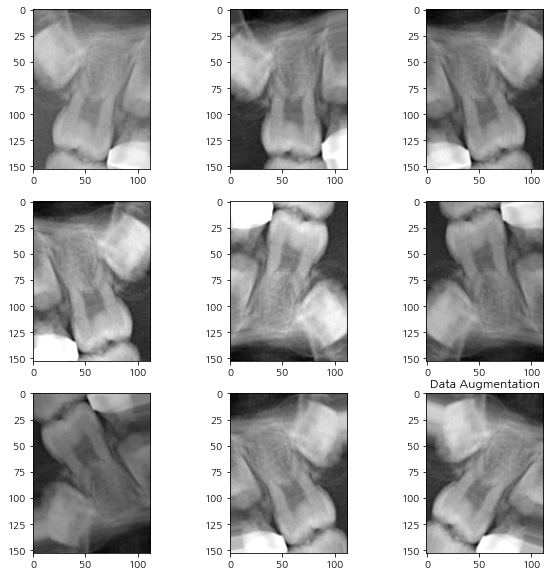

In [11]:
import matplotlib.pyplot as plt

img = load_img('../sungjin/tooth/test/0/20681492 박서현 16.png')
data = img_to_array(img)
samples = np.expand_dims(data, 0)

datagen.fit(train_img)
datagen.fit(test_img)


it = datagen.flow(samples, batch_size=32)

fig = plt.figure(figsize = (10,10))

plt.subplot(3,3,1)
plt.imshow(img)

# 9개 이미지 생성
for i in range(8):
    plt.subplot(3, 3, i+2)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

# show the figure
plt.title("Data Augmentation")
plt.show()

## Transfer Learning

In [12]:
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,AveragePooling2D,Flatten,Dropout,GlobalAveragePooling2D,BatchNormalization, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# with tf.device('/gpu:3'):
#     base_model = keras.applications.ResNet152(
#         include_top=False,
#         weights="imagenet",
#         input_shape=(151,112,3)
#     )
#     x = keras.layers.GlobalAveragePooling2D()(base_model.output)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.Dense(2048,activation= 'relu')(x)
#     x = keras.layers.Dropout(0.5)(x)
#     predictions = keras.layers.Dense(3,activation = 'softmax')(x)
    

#     model = keras.models.Model(inputs = base_model.input,outputs =predictions)

#     model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001),
#                   loss = 'categorical_crossentropy',
#                   metrics = ['accuracy',])
    
#     history = model.fit(datagen.flow(train_img,train_label,batch_size=32),
#                         validation_data=datagen.flow(test_img,test_label,batch_size =32),
#                         batch_size = 32,
#                         epochs=25)

#     model.save("Last3.h5")

Epoch 1/25
94/94 [==============================] - 25s 265ms/step - loss: 1.0939 - accuracy: 0.5363 - val_loss: 0.9096 - val_accuracy: 0.5710
Epoch 2/25
94/94 [==============================] - 20s 215ms/step - loss: 0.8421 - accuracy: 0.6373 - val_loss: 1.0575 - val_accuracy: 0.5106
Epoch 3/25
94/94 [==============================] - 20s 213ms/step - loss: 0.7457 - accuracy: 0.6828 - val_loss: 1.1694 - val_accuracy: 0.4924
Epoch 4/25
94/94 [==============================] - 20s 214ms/step - loss: 0.6716 - accuracy: 0.7133 - val_loss: 1.0990 - val_accuracy: 0.5468
Epoch 5/25
94/94 [==============================] - 19s 198ms/step - loss: 0.6320 - accuracy: 0.7297 - val_loss: 1.2905 - val_accuracy: 0.4743
Epoch 6/25
94/94 [==============================] - 19s 203ms/step - loss: 0.6041 - accuracy: 0.7387 - val_loss: 1.0065 - val_accuracy: 0.5619
Epoch 7/25
94/94 [==============================] - 19s 200ms/step - loss: 0.5465 - accuracy: 0.7745 - val_loss: 0.8534 - val_accuracy: 0.6405

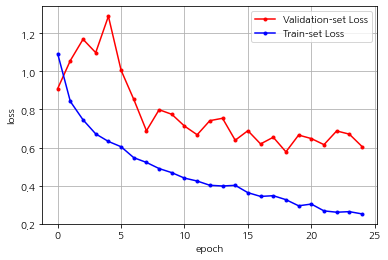

In [14]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

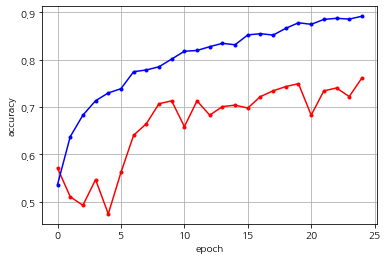

In [15]:
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_acc))

plt.plot(x_len, y_vacc, marker='.', c='red')
plt.plot(x_len, y_acc, marker='.', c='blue')

plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Predict 

In [16]:
from keras.models import load_model

model = load_model("Last.h5")

In [17]:
path = '../sungjin/tooth5/test/'
subdir = ['0/','20/','50/']
num = 0
idx = 0
count = 0

for sub in subdir:
    num = 0
    count = 0
    print("                                            "+subdir[idx])
    print("--------------------------------------------------------------------------------------")
    for file in os.listdir(path+sub):
        src_path = path + sub+file
        img = load_img(src_path, target_size = (151,112))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        preds = model.predict(x)
        if np.argmax(preds)==idx:
            count+=1
        num = num + 1
        
        
    print(" ")
    print("총"+ repr(num)+"개 중에"+repr(count)+"개 맞혔습니다.")
    print(repr((count/num)*100)+"% prediction")
    print()        
    idx +=1
    print(" ")
    


                                            0/
--------------------------------------------------------------------------------------
 
총159개 중에136개 맞혔습니다.
85.53459119496856% prediction

 
                                            20/
--------------------------------------------------------------------------------------
 
총115개 중에79개 맞혔습니다.
68.69565217391305% prediction

 
                                            50/
--------------------------------------------------------------------------------------
 
총57개 중에40개 맞혔습니다.
70.17543859649122% prediction

 


## Grad-CAM

In [18]:
from keras import layers
from keras import models
from keras import backend as K

import cv2

In [19]:
def gradCAM(image):
    conv_layer = model.get_layer("conv5_block3_3_conv")
    heatmap_model = models.Model([model.inputs],[conv_layer.output,model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(image) # y^c, c
        loss = predictions[:, np.argmax(predictions[0])] # probability
        grads = gtape.gradient(loss, conv_output) # partial-derivative
        pooled_grads = K.mean(grads, axis=(0, 1, 2)) # a_k^c , weight

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) # summation weight * filter
    heatmap = np.maximum(heatmap, 0) # ReLu
    max_heat = np.max(heatmap) # normalization    


    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    image = image[0]
    image = cv2.resize(image, (112,153))

    hm = heatmap[0]
    hm = cv2.resize(hm, (image.shape[1],image.shape[0]))
    hm = np.uint8(255*hm)
    hm = cv2.applyColorMap(hm,cv2.COLORMAP_JET)

    cvt_heatmap = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)

    superimposed_img = cvt_heatmap * 0.9 + image

    superimposed_img[superimposed_img > 255] = 255
    superimposed_img = superimposed_img.astype('uint8')


    return superimposed_img

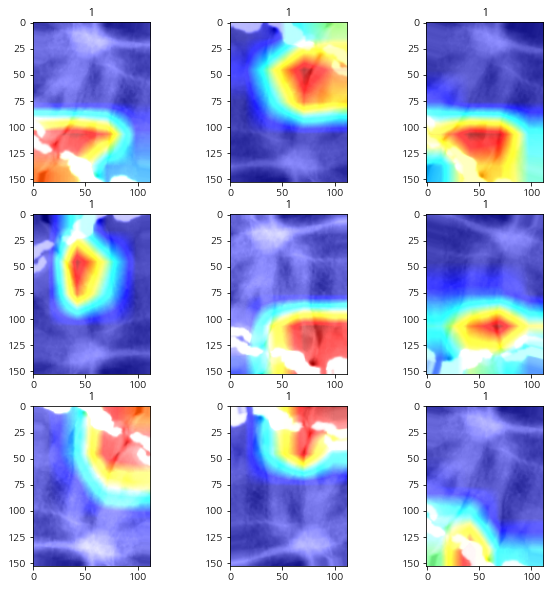

In [28]:
# img_path = '../sungjin/tooth5/test/0/20323665 한하은 26.png' # 3/9
# img_path = '../sungjin/tooth5/test/20/20328047 이지수 16.png' # 8/9
img_path = '../sungjin/tooth5/test/20/20108982 서윤경 16.png' # success
# img_path = '../sungjin/tooth5/test/50/20034499 조성희 16.png' # success
# img_path = '../sungjin/tooth5/test/50/20128817 전권태 46.png' # 5/9

img = load_img(img_path, target_size = (151,112))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

datagen.fit(train_img)
datagen.fit(test_img)


it = datagen.flow(x, batch_size=32)
fig = plt.figure(figsize = (10,10))

# layer which calculate `score class`-

# 9개 이미지 생성
for i in range(9):
    plt.subplot(3, 3, i+1)
    batch = it.next()
    
    image = gradCAM(batch)
    plt.imshow(image)
    predict = np.argmax(model.predict(batch))
    plt.title(predict)

# show the figure
plt.show()

## Majority Voting System

In [21]:
path = '../sungjin/tooth5/test/'
subdir = ['0/','20/','50/']

file_directory = []

for sub in subdir:
    dir = []
    for file in os.listdir(path+sub):
        name = file[0:12]
        dir.append(name)
    
    dir = list(set(dir))
    file_directory.append(dir)

In [22]:
old = ['16/','26/','36/','46/']
name_num = [' 16.png',' 26.png',' 36.png',' 46.png']
dir_num = 0

for idx in range(3):
    print("-----------------------------------------------")
    count = 0
    for name in file_directory[idx]:
        vote = [0,0,0]
        for number in range(4):
            src = path + subdir[idx] + name + name_num[number]
            if os.path.isfile(src):
                img = load_img(src, target_size = (151,112))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                predict = model.predict(x)
                vote += predict
        if np.argmax(vote) == 0:
#             print(name[9:12] + "의 나이는 0~19세 입니다.")
            if dir_num == 0:
                count +=1
        elif np.argmax(vote) == 1:
#             print(name[9:12] + "의 나이는 20~49세 입니다.")
            if dir_num == 1:
                count +=1
        else:
            if dir_num == 2:
                count +=1
#             print(name[9:12] + "의 나이는 50세 이상입니다.")
            
    print("총" + repr(len(file_directory[dir_num]))+"명 중 "+ repr(count)+ "명이 맞았습니다.    accuracy : " + repr(count/len(file_directory[dir_num])))
    dir_num += 1

-----------------------------------------------
총40명 중 37명이 맞았습니다.    accuracy : 0.925
-----------------------------------------------
총30명 중 20명이 맞았습니다.    accuracy : 0.6666666666666666
-----------------------------------------------
총19명 중 16명이 맞았습니다.    accuracy : 0.8421052631578947


## ROC-AUC

In [23]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve

In [24]:
def rocauc(label_num):
    p = model.predict(test_img, verbose=True)
    pre = pd.DataFrame(p)
    pre["predict"] = pre.idxmax(axis=1)
    pre["predict"] = (pre["predict"]==label_num).apply(int)
    label = np.argmax(test_label,axis = 1).reshape(-1,1)
    pre["label"] = label
    pre["label"] = (pre["label"]==label_num).apply(int)
    tpr,fpr,thres = roc_curve(pre["label"],pre[label_num])
    roc = pd.DataFrame([tpr,fpr]).T
    roc.plot(x=0,y=1)
    print("AUC : "+ repr(roc_auc_score(pre["label"],pre[label_num])))
    

11/11 [==============================] - 0s 32ms/step
AUC : 0.9440178440836624


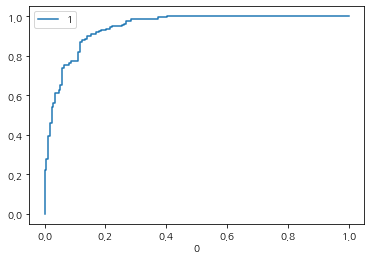

In [25]:
rocauc(0)

11/11 [==============================] - 0s 32ms/step
AUC : 0.8506038647342996


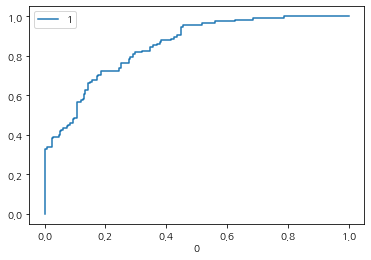

In [26]:
rocauc(1)

11/11 [==============================] - 0s 32ms/step
AUC : 0.9236778076578307


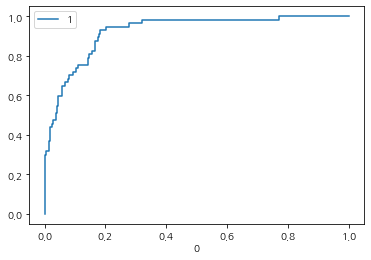

In [27]:
rocauc(2)

## Return GPU resources

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}